In [1]:
import sys
from YoloSamPipeline import YoloSam

/opt/conda/envs/env_py311/lib/python3.11/site-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/opt/conda/envs/env_py311/lib/python3.11/site-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/opt/conda/envs/env_py311/lib/python3.11/site-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing name. Please chec

In [2]:
yolo_path = './yolov8-segm-ft_no_stars-n-iter1/yolov8n-seg/weights/last.pt'
efficient_vit_enc = '/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/MobileSAMv2/weight/l2.pt'
# raid/OM_DeepLearning/XMM_OM_code_git/output_sam/ft_mobile_sam_final_2024-04-27 00:02:11.627528_last.pth
yolo_sam_pipeline = YoloSam(
    device='cuda:0', 
    yolo_checkpoint=yolo_path, 
    sam_checkpoint='./output_sam/ft_mobile_sam_final_2024-04-27 00:02:11.627528_last.pth', # the checkpoint and model_type (vit_h, vit_t, etc.) must be compatible
    model_type='vit_t',
    efficient_vit_enc=None,
    yolo_conf=0.3)

/opt/conda/envs/env_py311/lib/python3.11/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(


Number of object detected: 4
Iou predictions: tensor([0.7428, 0.7484, 0.8029, 0.9028])
Unique classes detected: 2
   read-out-streak

   smoke-ring

self.sam_predictor.input_size (977, 1024)
Inference time: 0:00:03.343220


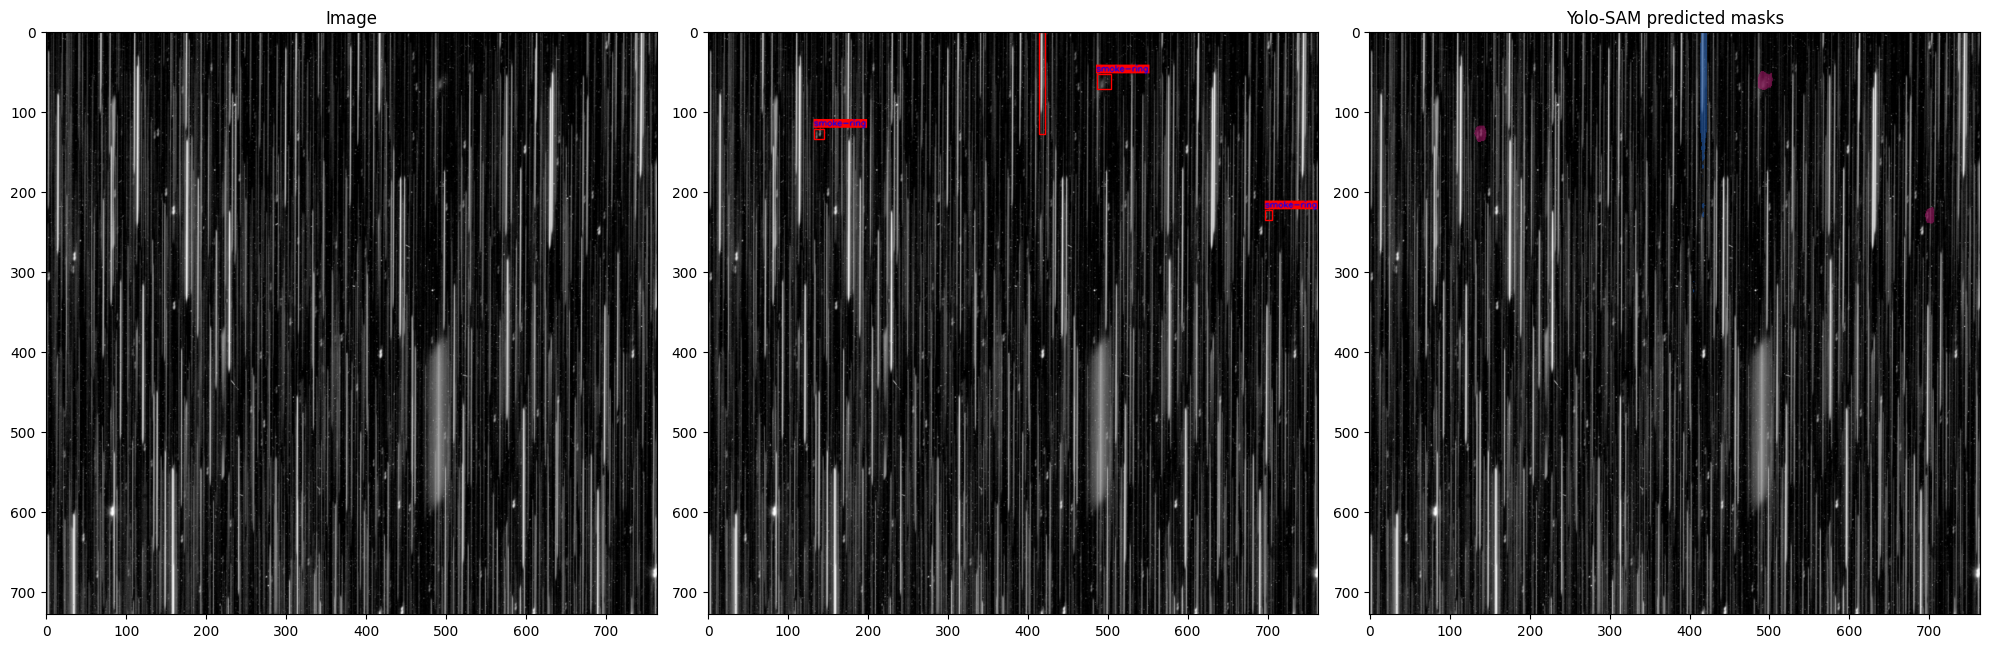

In [3]:
# masks = yolo_sam_pipeline.run_predict('../XMM_OM_dataset/zscaled_512_stretched/S0673000133_L.png') 
masks = yolo_sam_pipeline.run_predict('./Euclid-Grism-mode-caption1-768x768.png') 